In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.losses import MeanSquaredError

In [3]:
df = pd.read_csv(r"F:\College\SEM 8\Project Phase 2\Dataset\NCA Preprocessed\master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [5]:


# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)  
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [4]:
from tqdm import tqdm 

batch_size = 32

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)

In [5]:
def jsma_attack(model, x_ic_batch, x_ctx_batch, y_batch, epsilon=0.7, k=3,
                clip_min=-3.0, clip_max=3.0, sample_limit=None):
    
    X_ic_np = x_ic_batch.numpy()
    X_ctx_np = x_ctx_batch.numpy()
    y_np = y_batch.numpy()

    if sample_limit is not None:
        indices = np.random.choice(len(X_ic_np), size=sample_limit, replace=False)
    else:
        indices = range(len(X_ic_np))

    X_ic_adv = X_ic_np.copy()

    for i in indices:
        x_var = tf.Variable(X_ic_np[i:i+1], dtype=tf.float32)
        context_sample = tf.convert_to_tensor(X_ctx_np[i:i+1], dtype=tf.float32)
        y_true = tf.convert_to_tensor(y_np[i:i+1], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(x_var)
            y_pred = model([x_var, context_sample], training=False)
            loss = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

        gradient = tape.gradient(loss, x_var)
        if gradient is None:
            continue

        grad_np = gradient.numpy().reshape(-1)
        saliency = np.abs(grad_np)
        top_k = np.argsort(saliency)[-k:]

        for idx in top_k:
            X_ic_adv[i, idx, 0] += epsilon * np.sign(grad_np[idx])

    X_ic_adv = np.clip(X_ic_adv, clip_min, clip_max)

    return tf.convert_to_tensor(X_ic_adv, dtype=tf.float32)


In [6]:
cnn_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_lstm.keras")

In [ ]:
epsilon = 0.05 
learning_rate = 1e-5

best_val_mse = float('inf')
patience = 5
patience_counter = 0
epochs = 20

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_loss_fn = MeanSquaredError()

train_mae_history = []
train_mse_history = []
val_mse_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0 

    train_pbar = tqdm(train_dataset, desc = "Training", leave=True)

    for(x_ic_batch , x_ctx_batch, y_batch) in train_pbar:

        x_adv = jsma_attack(cnn_lstm, x_ic_batch, x_ctx_batch, y_batch, sample_limit = 0)


        with tf.GradientTape() as tape:
            y_pred_adv = cnn_lstm([x_adv, x_ctx_batch], training = True)
            mse_loss = mse_loss_fn(y_batch,y_pred_adv)

        grads = tape.gradient(mse_loss, cnn_lstm.trainable_variables)
        optimizer.apply_gradients(zip(grads, cnn_lstm.trainable_variables))

        mae_metric.reset_state()
        mae_metric.update_state(y_batch, y_pred_adv)
        batch_mae = mae_metric.result().numpy()

        total_mse += mse_loss.numpy()
        total_mae += batch_mae
        num_batches+=1

        train_pbar.set_postfix(mse = f"{mse_loss.numpy():.4f}", mae=f"{batch_mae:.4f}")


    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)


    print(f"Train MSE: {avg_mse:.4f} | Train MAE : {avg_mae:.4f}")

    val_mse = 0.0
    num_val_batches = 0

    val_pbar = tqdm(test_dataset, desc = "Validating", leave=True)

    for(x_ic_batch,x_ctx_batch, y_batch) in val_pbar:
        pred_val = cnn_lstm([x_ic_batch, x_ctx_batch], training=False)
        batch_mse= mse_loss_fn(y_batch, pred_val).numpy()

        val_mse += batch_mse
        num_val_batches += 1

        val_pbar.set_postfix(mse=f"{batch_mse:.4f}")

    
    val_mse /=num_val_batches
    val_mse_history.append(val_mse)

    print(f"Validation MSE: {val_mse:.4f}")

    if val_mse < best_val_mse:
        print("Validation improved, saving model ...")
        best_val_mse = val_mse
        patience_counter = 0
        cnn_lstm.save("jsma_trained_cnn_lstm.keras")

    else:
        patience_counter +=1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break   


Epoch 1/20


Training:   0%|          | 0/566 [00:00<?, ?it/s]

Training: 100%|██████████| 566/566 [02:06<00:00,  4.48it/s, mae=0.2498, mse=0.1236]


Train MSE: 0.1612 | Train MAE : 0.2998


Validating: 100%|██████████| 142/142 [00:09<00:00, 14.76it/s, mse=0.0757]


Validation MSE: 0.0778
Validation improved, saving model ...

Epoch 2/20


Training: 100%|██████████| 566/566 [02:09<00:00,  4.37it/s, mae=0.2092, mse=0.1294]


Train MSE: 0.0742 | Train MAE : 0.1973


Validating: 100%|██████████| 142/142 [00:11<00:00, 12.40it/s, mse=0.0279]


Validation MSE: 0.0336
Validation improved, saving model ...

Epoch 3/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.62it/s, mae=0.1266, mse=0.0256]


Train MSE: 0.0520 | Train MAE : 0.1657


Validating: 100%|██████████| 142/142 [00:10<00:00, 13.40it/s, mse=0.0175]


Validation MSE: 0.0216
Validation improved, saving model ...

Epoch 4/20


Training: 100%|██████████| 566/566 [02:15<00:00,  4.18it/s, mae=0.1206, mse=0.0223]


Train MSE: 0.0422 | Train MAE : 0.1508


Validating: 100%|██████████| 142/142 [00:09<00:00, 15.65it/s, mse=0.0106]


Validation MSE: 0.0148
Validation improved, saving model ...

Epoch 5/20


Training: 100%|██████████| 566/566 [02:03<00:00,  4.59it/s, mae=0.1437, mse=0.0443]


Train MSE: 0.0386 | Train MAE : 0.1425


Validating: 100%|██████████| 142/142 [00:09<00:00, 15.55it/s, mse=0.0093]


Validation MSE: 0.0115
Validation improved, saving model ...

Epoch 6/20


Training: 100%|██████████| 566/566 [02:06<00:00,  4.46it/s, mae=0.1471, mse=0.0413]


Train MSE: 0.0345 | Train MAE : 0.1339


Validating: 100%|██████████| 142/142 [00:09<00:00, 15.62it/s, mse=0.0073]


Validation MSE: 0.0092
Validation improved, saving model ...

Epoch 7/20


Training: 100%|██████████| 566/566 [01:21<00:00,  6.98it/s, mae=0.0715, mse=0.0118]


Train MSE: 0.0328 | Train MAE : 0.1291


Validating: 100%|██████████| 142/142 [00:02<00:00, 59.20it/s, mse=0.0074]


Validation MSE: 0.0082
Validation improved, saving model ...

Epoch 8/20


Training: 100%|██████████| 566/566 [00:30<00:00, 18.48it/s, mae=0.1087, mse=0.0186]


Train MSE: 0.0321 | Train MAE : 0.1268


Validating: 100%|██████████| 142/142 [00:02<00:00, 58.41it/s, mse=0.0073]


Validation MSE: 0.0076
Validation improved, saving model ...

Epoch 9/20


Training: 100%|██████████| 566/566 [00:31<00:00, 17.96it/s, mae=0.1430, mse=0.0309]


Train MSE: 0.0314 | Train MAE : 0.1247


Validating: 100%|██████████| 142/142 [00:02<00:00, 57.50it/s, mse=0.0056]


Validation MSE: 0.0066
Validation improved, saving model ...

Epoch 10/20


Training: 100%|██████████| 566/566 [00:32<00:00, 17.64it/s, mae=0.0982, mse=0.0144]


Train MSE: 0.0295 | Train MAE : 0.1212


Validating: 100%|██████████| 142/142 [00:02<00:00, 55.96it/s, mse=0.0052]


Validation MSE: 0.0062
Validation improved, saving model ...

Epoch 11/20


Training: 100%|██████████| 566/566 [00:33<00:00, 16.66it/s, mae=0.1136, mse=0.0244]


Train MSE: 0.0293 | Train MAE : 0.1207


Validating: 100%|██████████| 142/142 [00:02<00:00, 50.39it/s, mse=0.0043]


Validation MSE: 0.0055
Validation improved, saving model ...

Epoch 12/20


Training: 100%|██████████| 566/566 [00:33<00:00, 16.72it/s, mae=0.1350, mse=0.0281]


Train MSE: 0.0288 | Train MAE : 0.1198


Validating: 100%|██████████| 142/142 [00:02<00:00, 49.71it/s, mse=0.0043]


Validation MSE: 0.0054
Validation improved, saving model ...

Epoch 13/20


Training: 100%|██████████| 566/566 [00:35<00:00, 16.01it/s, mae=0.1136, mse=0.0199]


Train MSE: 0.0284 | Train MAE : 0.1184


Validating: 100%|██████████| 142/142 [00:02<00:00, 50.73it/s, mse=0.0043]


Validation MSE: 0.0055
No improvement. Patience: 1/5

Epoch 14/20


Training: 100%|██████████| 566/566 [01:15<00:00,  7.51it/s, mae=0.0678, mse=0.0093]


Train MSE: 0.0276 | Train MAE : 0.1170


Validating: 100%|██████████| 142/142 [00:09<00:00, 15.65it/s, mse=0.0037]


Validation MSE: 0.0051
Validation improved, saving model ...

Epoch 15/20


Training: 100%|██████████| 566/566 [01:01<00:00,  9.15it/s, mae=0.1174, mse=0.0210]


Train MSE: 0.0277 | Train MAE : 0.1164


Validating: 100%|██████████| 142/142 [00:02<00:00, 59.37it/s, mse=0.0035]


Validation MSE: 0.0049
Validation improved, saving model ...

Epoch 16/20


Training: 100%|██████████| 566/566 [00:34<00:00, 16.57it/s, mae=0.0941, mse=0.0215]


Train MSE: 0.0274 | Train MAE : 0.1163


Validating: 100%|██████████| 142/142 [00:03<00:00, 44.97it/s, mse=0.0039]


Validation MSE: 0.0052
No improvement. Patience: 1/5

Epoch 17/20


Training: 100%|██████████| 566/566 [01:02<00:00,  9.08it/s, mae=0.1206, mse=0.0253]


Train MSE: 0.0274 | Train MAE : 0.1164


Validating: 100%|██████████| 142/142 [00:06<00:00, 21.82it/s, mse=0.0030]


Validation MSE: 0.0046
Validation improved, saving model ...

Epoch 18/20


Training: 100%|██████████| 566/566 [01:24<00:00,  6.68it/s, mae=0.0936, mse=0.0171]


Train MSE: 0.0270 | Train MAE : 0.1145


Validating: 100%|██████████| 142/142 [00:05<00:00, 28.27it/s, mse=0.0037]


Validation MSE: 0.0049
No improvement. Patience: 1/5

Epoch 19/20


Training: 100%|██████████| 566/566 [00:32<00:00, 17.57it/s, mae=0.1126, mse=0.0228]


Train MSE: 0.0263 | Train MAE : 0.1138


Validating: 100%|██████████| 142/142 [00:02<00:00, 48.44it/s, mse=0.0038]


Validation MSE: 0.0049
No improvement. Patience: 2/5

Epoch 20/20


Training: 100%|██████████| 566/566 [00:37<00:00, 14.93it/s, mae=0.1379, mse=0.0330]


Train MSE: 0.0264 | Train MAE : 0.1136


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.97it/s, mse=0.0032]

Validation MSE: 0.0046
Validation improved, saving model ...


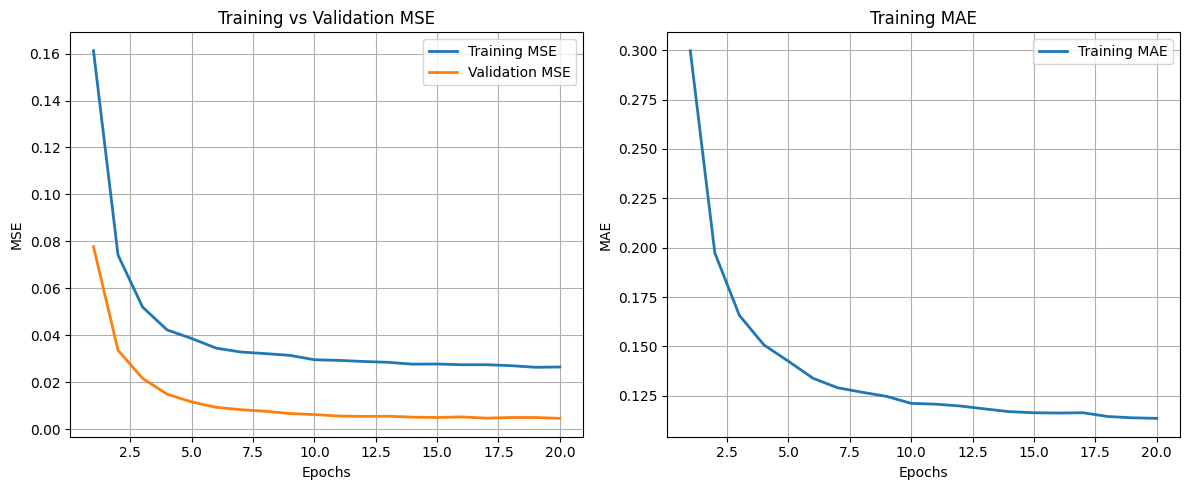

Saved training curves to adv_training_curves_jsma_lstm.png


In [9]:
import matplotlib.pyplot as plt

# Number of epochs actually completed
epochs_ran = len(train_mse_history)

plt.figure(figsize=(12, 5))

# ---------------- MSE Plot ----------------
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), train_mse_history, label='Training MSE', linewidth=2)
plt.plot(range(1, epochs_ran + 1), val_mse_history, label='Validation MSE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE")
plt.legend()
plt.grid(True)

# ---------------- MAE Plot ----------------
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), train_mae_history, label='Training MAE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("adv_training_curves_jsma_lstm.png", dpi=300)
plt.show()

print("Saved training curves to adv_training_curves_jsma_lstm.png")


In [6]:
adv_jsma_lstm = keras.models.load_model("F:\College\SEM 8\Project Phase 2\Adversarial Training\jsma_trained_cnn_lstm.keras")

In [7]:


# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)  
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


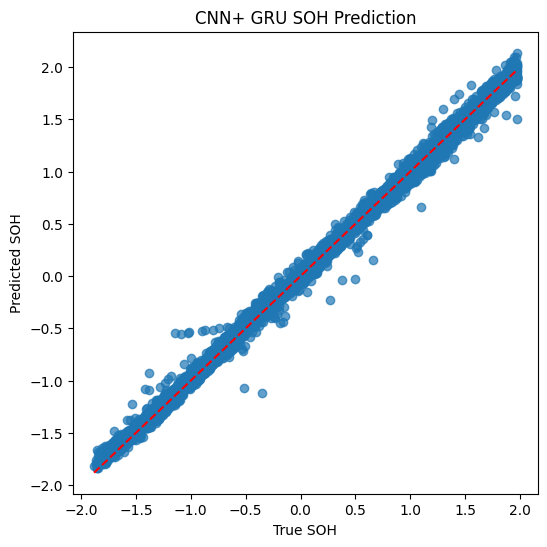

In [8]:
import matplotlib.pyplot as plt

y_pred = adv_jsma_lstm.predict([X_ic_test, X_context_test]).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.title("CNN+ GRU SOH Prediction")
plt.show()

In [9]:
def jsma_attack(model, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3):

    X_ic_np = np.array(X_ic_test, dtype=np.float32)
    X_context_np = np.array(X_context_test, dtype=np.float32)
    y_np = np.array(y_test, dtype=np.float32)

    X_ic_adv = X_ic_np.copy()

    for i in range(X_ic_np.shape[0]):
        
        x_var = tf.Variable(X_ic_np[i:i+1], dtype=tf.float32)
        context_sample = tf.convert_to_tensor(X_context_np[i:i+1], dtype=tf.float32)
        y_true = tf.convert_to_tensor(y_np[i:i+1], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(x_var)
            y_pred = model([x_var, context_sample], training=False)
            loss = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

        gradient = tape.gradient(loss, x_var)
        if gradient is None:
            # Skip this sample if gradient couldn't be computed
            continue

        # Convert gradient to 1D numpy array aligned with timesteps
        grad_np = gradient.numpy().reshape(-1)

        # Saliency = absolute gradient magnitude per timestep
        saliency = np.abs(grad_np)
        
        # Pick top-k timesteps to perturb
        indices = np.argsort(saliency)[-k:]

        for idx in indices:
            # idx indexes the flattened timestep dimension; for shape (1, T, 1) flatten -> T
            X_ic_adv[i, idx, 0] += epsilon * np.sign(grad_np[idx])

    X_ic_adv = np.clip(X_ic_adv, -3.0, 3.0)

    return X_ic_adv

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

def attack_eval(model, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3, model_name=""):
    # Ensure numpy arrays with correct dtype and 1D targets
    X_ic_test = np.array(X_ic_test, dtype=np.float32)
    X_context_test = np.array(X_context_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32).ravel()

    # Generate adversarial IC inputs (returns numpy or tensor-like)
    X_ic_test_adv = jsma_attack(model, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3)

    # Get predictions and ensure they are 1D numpy arrays
    y_pred = np.array(model.predict([X_ic_test, X_context_test])).ravel()
    y_pred_adv = np.array(model.predict([X_ic_test_adv, X_context_test])).ravel()

    # Compute metrics on flattened arrays
    print("-----------------")
    print("Normal Condition")
    print("-----------------")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

    print("-------------")
    print("Attacked Data")
    print("-------------")
    print("R2 Score:", r2_score(y_test, y_pred_adv))
    print("MAE:", mean_absolute_error(y_test, y_pred_adv))
    print("MSE:", mean_squared_error(y_test, y_pred_adv))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_adv))

    print("-----")
    print("Plots")
    print("-----")

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.title(model_name+" Clean Data Predictions")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
    plt.title(model_name+" Attacked Data Predicitions")
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9954516887664795
MAE: 0.04840698838233948
MSE: 0.00456078490242362
MAPE: 0.6008520126342773
-------------
Attacked Data
-------------
R2 Score: 0.8783783316612244
MAE: 0.3195788264274597
MSE: 0.12195534259080887
MAPE: 18.47115707397461
-----
Plots
-----


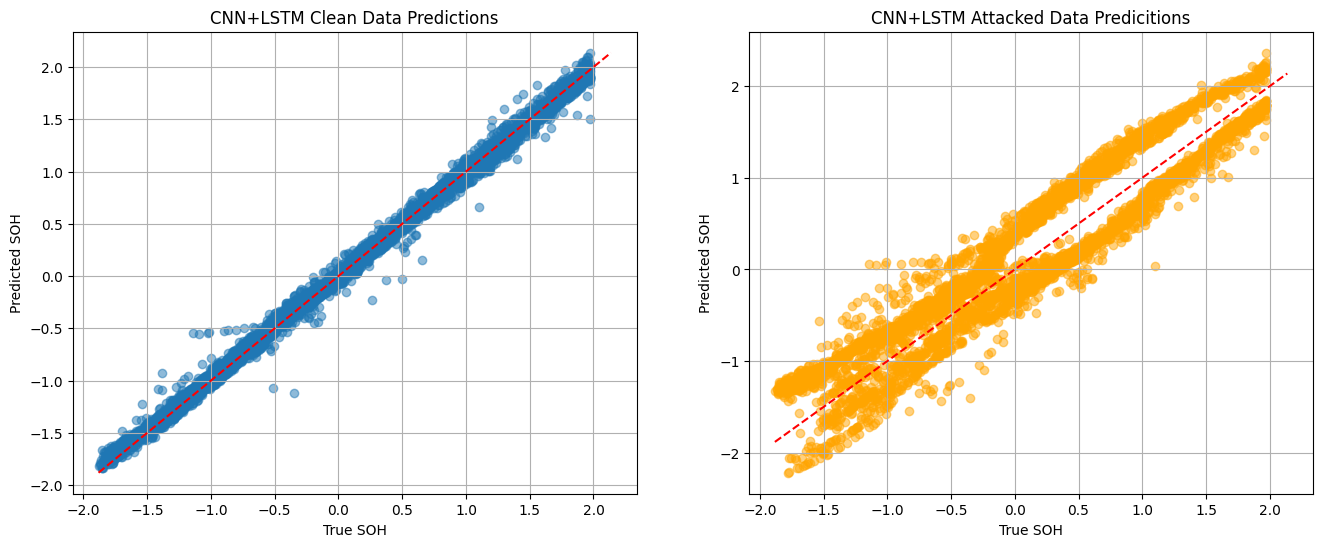

In [11]:
attack_eval(adv_jsma_lstm, X_ic_test, X_context_test, y_test, epsilon=0.7, k=3, model_name="CNN+LSTM")
